In [33]:
import importlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import itertools
from Data import ImageTextData, split_dataset,clean_multilabel_csv,clean_test_csv
from ResNet import train_ResNet
from Plot import plot_label_distribution
from TinyBert import prepare_tinybert_dataloaders_from_csv,train_tinybert_caption_classifier
from ViTTiny import prepare_vitonly_dataloaders, train_vitonly
from Multimodality import prepare_multimodality_dataloaders,train_clip_and_classify
from Predict import predict_miniclip_ablation
from Utils import custom_collate

# 1.Data Processing
- Errors in processing data
- Check label distribution
- Divide a small dataset (1000) for training and evaluating the model
- Divide a middle dataset (5000) for ablation study


In [31]:
# Errors in processing train data
raw_file = f'Data/train.csv'
clean_file = f'train_clean.csv'
# Handling errors in caption
if not os.path.exists(clean_file):
    clean_multilabel_csv(raw_file, clean_file)

In [32]:
# Errors in processing train data
test_raw_file = f'Data/test.csv'
test_clean_file = f'test_clean.csv'
# Handling errors in caption
if not os.path.exists(test_clean_file):
    clean_test_csv(test_raw_file, test_clean_file)

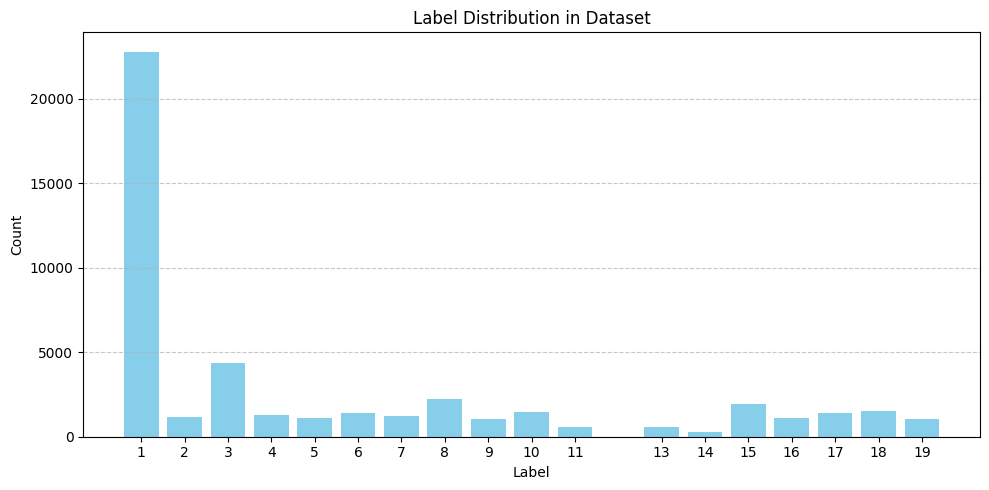

In [ ]:
# Check label distribution
df = pd.read_csv('train_clean.csv')
plot_label_distribution(df)

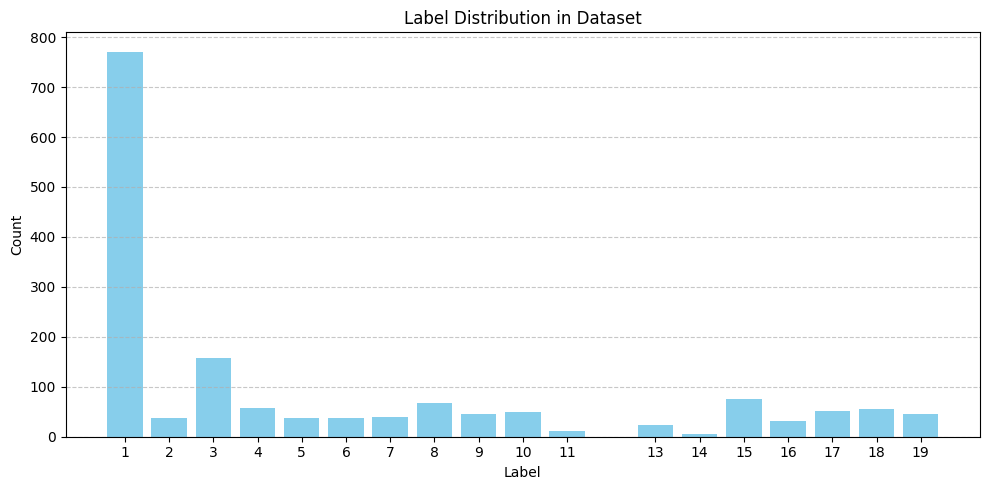

In [ ]:
# Create a dataset of 1000 entries
df1000 = df.sample(n=1000, random_state=42).reset_index(drop=True)
# Check data distribution
plot_label_distribution(df1000)

In [ ]:
#Divide a small dataset (1000) for training and evaluating the model
df1000.to_csv('train1000.csv', index=False)

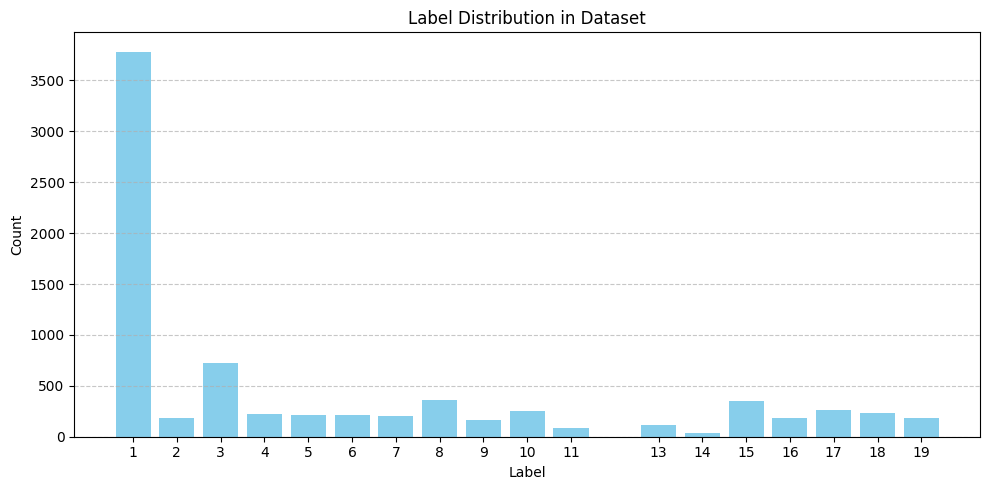

In [ ]:
# Create a dataset of 5000 entries
df5000 = df.sample(n=5000, random_state=42).reset_index(drop=True)
# Check data distribution
plot_label_distribution(df5000)
#Divide a middle dataset (5000) for ablation study
df5000.to_csv('train5000.csv', index=False)

# 2.Model Train
- 2.1 ResNet
    - ResNet-18
    - ResNet-34
- 2.2 Mini
- 2.3 BLIP
- 2.4 Multimodality
- 2.5 Comparison of model performance

## 2.1 ResNet
- Processing dataset for train
  - Divide the data into 80% training set and 20% test set
  - Processing data that can be used for ResNet
- ResNet18
- ResNet34


### 2.1.1 Processing dataset for train

In [ ]:
# Load 1000 records
small_dataset = ImageTextData(data="train1000", transform=True, size=1000,sample_mode='random', aug_type="none", resize_shape=(224, 224))
# Split train and val
# train_loader, val_loader = split_dataset(small_dataset, batch_size=100, seed=42)
res_train, res_val = split_dataset(small_dataset, batch_size=100, seed=42)
# View a batch example
for images, texts, labels in res_train:
    print(images.shape)     # [batch_size, 3, 256, 256]
    print(texts[0])         # caption
    print(labels[0])        # one-hot label
    break

torch.Size([100, 3, 224, 224])
"A shirtless man in swim trunks playing with a flying disk on a beach."
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


### 2.1.2 ResNet18

In [ ]:
resnet18_result = train_ResNet(
    res_train, res_val,
    num_labels=18,
    num_epochs=30,
    backbone="resnet18",
    lr=1e-4,
    weight_decay=1e-4,
    patience=5,
    dropout_rate=0.3,
    seed=42,
    use_asymmetric_loss=False
)

[Epoch 1/30] Train Loss: 0.7472,Train F1: 0.1830 | Val Loss: 0.6268, Val F1: 0.2611
[Epoch 2/30] Train Loss: 0.5621,Train F1: 0.3197 | Val Loss: 0.4916, Val F1: 0.4007
[Epoch 3/30] Train Loss: 0.4301,Train F1: 0.5040 | Val Loss: 0.4044, Val F1: 0.5397
[Epoch 4/30] Train Loss: 0.3340,Train F1: 0.6973 | Val Loss: 0.3440, Val F1: 0.6290
[Epoch 5/30] Train Loss: 0.2614,Train F1: 0.8184 | Val Loss: 0.2925, Val F1: 0.6762
[Epoch 6/30] Train Loss: 0.2118,Train F1: 0.8711 | Val Loss: 0.2529, Val F1: 0.6801
[Epoch 7/30] Train Loss: 0.1723,Train F1: 0.9103 | Val Loss: 0.2242, Val F1: 0.6817
[Epoch 8/30] Train Loss: 0.1444,Train F1: 0.9368 | Val Loss: 0.2040, Val F1: 0.6768
[Epoch 9/30] Train Loss: 0.1218,Train F1: 0.9561 | Val Loss: 0.1924, Val F1: 0.6782
[Epoch 10/30] Train Loss: 0.1051,Train F1: 0.9653 | Val Loss: 0.1835, Val F1: 0.6795
[Epoch 11/30] Train Loss: 0.0945,Train F1: 0.9807 | Val Loss: 0.1789, Val F1: 0.6794
[Epoch 12/30] Train Loss: 0.0875,Train F1: 0.9839 | Val Loss: 0.1755, Val 

### 2.1.3 ResNet34

In [ ]:
resnet34_bce_result = train_ResNet(
    res_train, res_val,
    num_labels=18,
    num_epochs=30,
    backbone="resnet34",
    lr=1e-4,
    weight_decay=5e-5,
    patience=5,
    dropout_rate=0.3,
    seed=42,
    use_asymmetric_loss=False
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 184MB/s]


[Epoch 1/30] Train Loss: 0.7466,Train F1: 0.2011 | Val Loss: 0.6411, Val F1: 0.2715
[Epoch 2/30] Train Loss: 0.5299,Train F1: 0.3698 | Val Loss: 0.4784, Val F1: 0.4205
[Epoch 3/30] Train Loss: 0.3829,Train F1: 0.5717 | Val Loss: 0.3797, Val F1: 0.5501
[Epoch 4/30] Train Loss: 0.2873,Train F1: 0.7311 | Val Loss: 0.3123, Val F1: 0.6408
[Epoch 5/30] Train Loss: 0.2189,Train F1: 0.8272 | Val Loss: 0.2572, Val F1: 0.6809
[Epoch 6/30] Train Loss: 0.1717,Train F1: 0.8901 | Val Loss: 0.2200, Val F1: 0.7055
[Epoch 7/30] Train Loss: 0.1379,Train F1: 0.9318 | Val Loss: 0.1947, Val F1: 0.7085
[Epoch 8/30] Train Loss: 0.1117,Train F1: 0.9584 | Val Loss: 0.1787, Val F1: 0.7105
[Epoch 9/30] Train Loss: 0.0954,Train F1: 0.9742 | Val Loss: 0.1691, Val F1: 0.7054
[Epoch 10/30] Train Loss: 0.0807,Train F1: 0.9831 | Val Loss: 0.1626, Val F1: 0.7094
[Epoch 11/30] Train Loss: 0.0687,Train F1: 0.9914 | Val Loss: 0.1579, Val F1: 0.7151
[Epoch 12/30] Train Loss: 0.0596,Train F1: 0.9961 | Val Loss: 0.1547, Val 

## 2.2 Tiny-BERT
- Processing dataset for train
  - Divide the data into 80% training set and 20% test set
  - Processing data that can be used for Tiny-BERT
- Training model

In [ ]:
bert_train, bert_val = prepare_tinybert_dataloaders_from_csv(
    csv_path="train1000.csv",
    tokenizer_path="tinybert",
    batch_size=16,
    num_labels=18,
    train_ratio=0.8
)

In [ ]:
# train bert
bert_result = train_tinybert_caption_classifier(bert_train, bert_val,num_labels=18, num_epochs=30,seed=42, patience=5)

[Epoch 1/30] Train Loss: 0.6458,Train F1: 0.1905 | Val Loss: 0.5513, Val F1: 0.6051
[Epoch 2/30] Train Loss: 0.3631,Train F1: 0.6007 | Val Loss: 0.2059, Val F1: 0.6051
[Epoch 3/30] Train Loss: 0.2064,Train F1: 0.6028 | Val Loss: 0.1966, Val F1: 0.6051
[Epoch 4/30] Train Loss: 0.2035,Train F1: 0.6028 | Val Loss: 0.1949, Val F1: 0.6051
[Epoch 5/30] Train Loss: 0.2018,Train F1: 0.6028 | Val Loss: 0.1945, Val F1: 0.6051
[Epoch 6/30] Train Loss: 0.2009,Train F1: 0.6028 | Val Loss: 0.1940, Val F1: 0.6051
Early stopping triggered at epoch 6


## 2.3 ViT
- Processing dataset for train
  - Divide the data into 80% training set and 20% test set
  - Processing data that can be used for ViT
- Training model

In [ ]:
vit_train, vit_val = prepare_vitonly_dataloaders(
    csv_file="train1000.csv",
    image_root="COMP5329S1A2Dataset/data",
    batch_size=16,
    num_labels=18,
    train_ratio=0.8
)

In [ ]:
vit_result = train_vitonly(
    vit_train, vit_val,
    num_labels=18,
    num_epochs=30,
    lr=1e-4,
    weight_decay=1e-5,
    dropout_rate=0.2,
    threshold=0.3
)

[Epoch 1/30] Train Loss: 0.4758,Train F1: 0.1855 | Val Loss: 0.2502, Val F1: 0.5571
[Epoch 2/30] Train Loss: 0.2179,Train F1: 0.5687 | Val Loss: 0.1846, Val F1: 0.6124
[Epoch 3/30] Train Loss: 0.1910,Train F1: 0.6084 | Val Loss: 0.1727, Val F1: 0.6200
[Epoch 4/30] Train Loss: 0.1759,Train F1: 0.6193 | Val Loss: 0.1643, Val F1: 0.6231
[Epoch 5/30] Train Loss: 0.1667,Train F1: 0.6205 | Val Loss: 0.1579, Val F1: 0.6316
[Epoch 6/30] Train Loss: 0.1564,Train F1: 0.6555 | Val Loss: 0.1509, Val F1: 0.6456
[Epoch 7/30] Train Loss: 0.1491,Train F1: 0.6547 | Val Loss: 0.1446, Val F1: 0.6678
[Epoch 8/30] Train Loss: 0.1415,Train F1: 0.6856 | Val Loss: 0.1405, Val F1: 0.6745
[Epoch 9/30] Train Loss: 0.1343,Train F1: 0.6901 | Val Loss: 0.1367, Val F1: 0.6723
[Epoch 10/30] Train Loss: 0.1303,Train F1: 0.7060 | Val Loss: 0.1357, Val F1: 0.6755
[Epoch 11/30] Train Loss: 0.1247,Train F1: 0.7177 | Val Loss: 0.1331, Val F1: 0.6868
[Epoch 12/30] Train Loss: 0.1189,Train F1: 0.7349 | Val Loss: 0.1295, Val 

## 2.4 Multimodality
- Processing dataset for train
  - Divide the data into 80% training set and 20% test set
  - Processing data that can be used for Multimodality
- Clip

In [ ]:
mul_train, mul_val = prepare_multimodality_dataloaders(
    csv_file="train1000.csv",
    image_root="Data/data",
    batch_size=16,
    num_labels=18,
    train_ratio=0.8
)

### 2.4.1 Clip
- Use clip like contrast learning before using in MLP as a classifier

In [ ]:
clip_result = train_clip_and_classify(
    train_loader=mul_train,
    val_loader=mul_val,
    num_labels=18,
    num_epochs_clip=20,
    clip_patience=3,
    num_epochs_cls=30,
    cls_patience=5,
    lr=1e-4,
    weight_decay=1e-5,
    threshold=0.3
)

--- Stage 1: CLIP contrastive training ---
[Epoch 1/20] CLIP Loss: 2.7925
[Epoch 2/20] CLIP Loss: 2.6497
[Epoch 3/20] CLIP Loss: 2.5242
[Epoch 4/20] CLIP Loss: 2.3495
[Epoch 5/20] CLIP Loss: 2.0909
[Epoch 6/20] CLIP Loss: 1.9282
[Epoch 7/20] CLIP Loss: 1.8664
[Epoch 8/20] CLIP Loss: 1.7473
[Epoch 9/20] CLIP Loss: 1.6940
[Epoch 10/20] CLIP Loss: 1.6539
[Epoch 11/20] CLIP Loss: 1.5897
[Epoch 12/20] CLIP Loss: 1.5626
[Epoch 13/20] CLIP Loss: 1.5799
[Epoch 14/20] CLIP Loss: 1.4975
[Epoch 15/20] CLIP Loss: 1.4679
[Epoch 16/20] CLIP Loss: 1.4555
[Epoch 17/20] CLIP Loss: 1.3676
[Epoch 18/20] CLIP Loss: 1.3839
[Epoch 19/20] CLIP Loss: 1.3583
[Epoch 20/20] CLIP Loss: 1.3493

--- Stage 2: MLP classification fine-tuning ---
[Epoch 1/30] Train Loss: 0.5140,Train F1: 0.1853 | Val Loss: 0.2913, Val F1: 0.5463
[Epoch 2/30] Train Loss: 0.2130,Train F1: 0.5726 | Val Loss: 0.1720, Val F1: 0.6100
[Epoch 3/30] Train Loss: 0.1729,Train F1: 0.6160 | Val Loss: 0.1613, Val F1: 0.6168
[Epoch 4/30] Train Loss: 

## 2.5 Comparison of model performance
- Loss and F1 in the training set of the comparison model
- Selection of the best model for ablation study

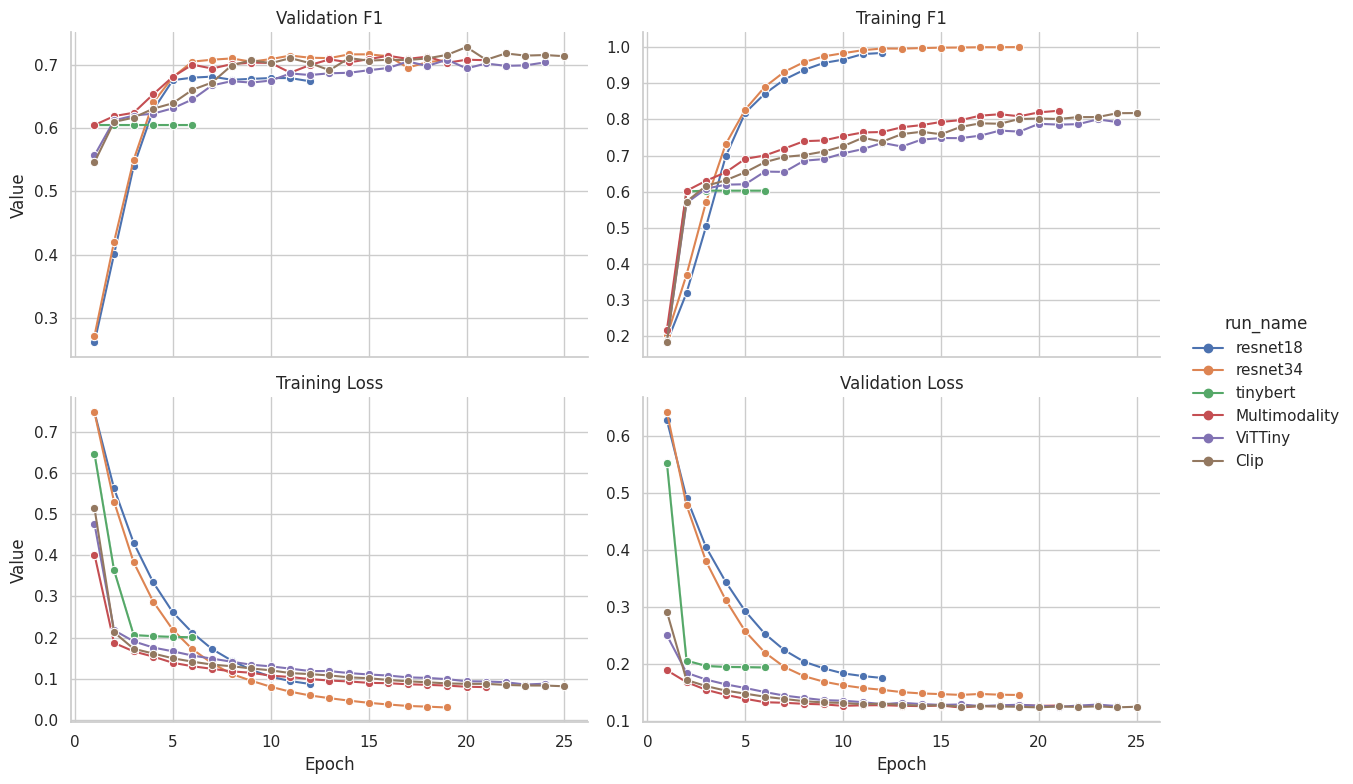

In [ ]:
# Read the file
file_path = 'training_log.csv'
df = pd.read_csv(file_path)

sns.set_theme(style="whitegrid")

# Reshape the data format to the long format、
train_f1_df = df[['run_name', 'epoch', 'train_f1']].copy()
train_f1_df['metric'] = 'Training F1'
train_f1_df.rename(columns={'train_f1': 'value'}, inplace=True)

val_f1_df = df[['run_name', 'epoch', 'val_f1']].copy()
val_f1_df['metric'] = 'Validation F1'
val_f1_df.rename(columns={'val_f1': 'value'}, inplace=True)

train_loss_df = df[['run_name', 'epoch', 'train_loss']].copy()
train_loss_df['metric'] = 'Training Loss'
train_loss_df.rename(columns={'train_loss': 'value'}, inplace=True)

val_loss_df = df[['run_name', 'epoch', 'val_loss']].copy()
val_loss_df['metric'] = 'Validation Loss'
val_loss_df.rename(columns={'val_loss': 'value'}, inplace=True)

# Merge data
long_df = pd.concat([val_f1_df, train_f1_df, train_loss_df, val_loss_df])

# Draw comparison charts
g = sns.relplot(
    data=long_df,
    kind="line",
    x="epoch",
    y="value",
    hue="run_name",
    col="metric",
    col_wrap=2,
    marker="o",
    facet_kws={'sharey': False, 'sharex': True},
    height=4,
    aspect=1.5
)

# Set graphic labels
g.set_titles("{col_name}")
g.set_axis_labels("Epoch", "Value")
g.tight_layout()
plt.show()


In [ ]:
# Find out the last epoch of each model
best_epochs = df.sort_values('epoch').groupby('run_name').last().reset_index()

# Select the model with the highest F1 verification
best_model_row = best_epochs.loc[best_epochs['val_f1'].idxmax()]
best_model_name = best_model_row['run_name']

# Print the result
print("Best Model for Ablation Study:")
print(f"Model Name: {best_model_name}")
print(best_model_row)


Best Model for Ablation Study:
Model Name: Clip
run_name                     Clip
epoch                          25
train_loss               0.081868
train_f1                 0.817495
val_loss                 0.125106
val_f1                   0.714055
timestamp     2025-05-24 05:03:01
Name: 0, dtype: object


# 3.Ablation Study
- Doing ablation study on 1000 dataset
  - Baseline Model
    - Dropout(0.3) + 2-layer MLP
  - Temperature parameter comparison
  - Activation
  - Dropout comparison
- Doing ablation study on 5000 dataset



## 3.1 Ablation study on 1000 dataset

### 3.1.1 Baseline Model

In [ ]:
# Baseline Model
clip_baseline_result = train_clip_and_classify(
    train_loader=mul_train,
    val_loader=mul_val,
    num_labels=18,
    num_epochs_clip=20,
    clip_patience=3,
    num_epochs_cls=30,
    cls_patience=5,
    lr=1e-4,
    weight_decay=1e-5,
    threshold=0.3,
    hidden_dims=[512, 256],
    activation='relu',
    proj_dim=312,
    temperature=0.07,
    csv_path='ablation_log.csv'
)

--- Stage 1: CLIP contrastive training ---
[Epoch 1/20] CLIP Loss: 2.7957
[Epoch 2/20] CLIP Loss: 2.6399
[Epoch 3/20] CLIP Loss: 2.5207
[Epoch 4/20] CLIP Loss: 2.3405
[Epoch 5/20] CLIP Loss: 2.1139
[Epoch 6/20] CLIP Loss: 1.9348
[Epoch 7/20] CLIP Loss: 1.8449
[Epoch 8/20] CLIP Loss: 1.8030
[Epoch 9/20] CLIP Loss: 1.6958
[Epoch 10/20] CLIP Loss: 1.6664
[Epoch 11/20] CLIP Loss: 1.6074
[Epoch 12/20] CLIP Loss: 1.5776
[Epoch 13/20] CLIP Loss: 1.5427
[Epoch 14/20] CLIP Loss: 1.4879
[Epoch 15/20] CLIP Loss: 1.4711
[Epoch 16/20] CLIP Loss: 1.4128
[Epoch 17/20] CLIP Loss: 1.4069
[Epoch 18/20] CLIP Loss: 1.4154
[Epoch 19/20] CLIP Loss: 1.3715
[Epoch 20/20] CLIP Loss: 1.3228

--- Stage 2: MLP classification fine-tuning ---
[Epoch 1/30] Train Loss: 0.5135,Train F1: 0.1839 | Val Loss: 0.2922, Val F1: 0.5519
[Epoch 2/30] Train Loss: 0.2133,Train F1: 0.5687 | Val Loss: 0.1716, Val F1: 0.6154
[Epoch 3/30] Train Loss: 0.1718,Train F1: 0.6181 | Val Loss: 0.1608, Val F1: 0.6180
[Epoch 4/30] Train Loss: 

### 3.1.2 Temperature parameter comparison

In [ ]:
# Baseline Model
clip_baseline_result = train_clip_and_classify(
    train_loader=mul_train,
    val_loader=mul_val,
    num_labels=18,
    num_epochs_clip=20,
    clip_patience=3,
    num_epochs_cls=30,
    cls_patience=5,
    lr=1e-4,
    weight_decay=1e-5,
    threshold=0.3,
    hidden_dims=[512, 256],
    activation='relu',
    proj_dim=312,
    temperature=0.05,
    file_name='Temperature005',
    csv_path='ablation_log.csv'
)

--- Stage 1: CLIP contrastive training ---
[Epoch 1/20] CLIP Loss: 2.8436
[Epoch 2/20] CLIP Loss: 2.6316
[Epoch 3/20] CLIP Loss: 2.5039
[Epoch 4/20] CLIP Loss: 2.3488
[Epoch 5/20] CLIP Loss: 2.1688
[Epoch 6/20] CLIP Loss: 1.9863
[Epoch 7/20] CLIP Loss: 1.8692
[Epoch 8/20] CLIP Loss: 1.8197
[Epoch 9/20] CLIP Loss: 1.6887
[Epoch 10/20] CLIP Loss: 1.6586
[Epoch 11/20] CLIP Loss: 1.5844
[Epoch 12/20] CLIP Loss: 1.5557
[Epoch 13/20] CLIP Loss: 1.5034
[Epoch 14/20] CLIP Loss: 1.4452
[Epoch 15/20] CLIP Loss: 1.4218
[Epoch 16/20] CLIP Loss: 1.3652
[Epoch 17/20] CLIP Loss: 1.3530
[Epoch 18/20] CLIP Loss: 1.3641
[Epoch 19/20] CLIP Loss: 1.3176
[Epoch 20/20] CLIP Loss: 1.2656

--- Stage 2: MLP classification fine-tuning ---
[Epoch 1/30] Train Loss: 0.4940,Train F1: 0.1899 | Val Loss: 0.2550, Val F1: 0.5894
[Epoch 2/30] Train Loss: 0.2034,Train F1: 0.5882 | Val Loss: 0.1714, Val F1: 0.6180
[Epoch 3/30] Train Loss: 0.1729,Train F1: 0.6230 | Val Loss: 0.1608, Val F1: 0.6154
[Epoch 4/30] Train Loss: 

In [ ]:
# Baseline Model
clip_baseline_result = train_clip_and_classify(
    train_loader=mul_train,
    val_loader=mul_val,
    num_labels=18,
    num_epochs_clip=20,
    clip_patience=3,
    num_epochs_cls=30,
    cls_patience=5,
    lr=1e-4,
    weight_decay=1e-5,
    threshold=0.3,
    hidden_dims=[512, 256],
    activation='relu',
    proj_dim=312,
    temperature=0.2,
    file_name='Temperature2',
    csv_path='ablation_log.csv'
)

--- Stage 1: CLIP contrastive training ---
[Epoch 1/20] CLIP Loss: 2.7637
[Epoch 2/20] CLIP Loss: 2.6985
[Epoch 3/20] CLIP Loss: 2.5973
[Epoch 4/20] CLIP Loss: 2.3925
[Epoch 5/20] CLIP Loss: 2.2670
[Epoch 6/20] CLIP Loss: 2.1776
[Epoch 7/20] CLIP Loss: 2.1236
[Epoch 8/20] CLIP Loss: 2.0855
[Epoch 9/20] CLIP Loss: 2.0231
[Epoch 10/20] CLIP Loss: 1.9880
[Epoch 11/20] CLIP Loss: 1.9489
[Epoch 12/20] CLIP Loss: 1.9136
[Epoch 13/20] CLIP Loss: 1.9081
[Epoch 14/20] CLIP Loss: 1.8656
[Epoch 15/20] CLIP Loss: 1.8541
[Epoch 16/20] CLIP Loss: 1.8043
[Epoch 17/20] CLIP Loss: 1.8124
[Epoch 18/20] CLIP Loss: 1.8025
[Epoch 19/20] CLIP Loss: 1.7843
[Epoch 20/20] CLIP Loss: 1.7383

--- Stage 2: MLP classification fine-tuning ---
[Epoch 1/30] Train Loss: 0.5137,Train F1: 0.1850 | Val Loss: 0.2975, Val F1: 0.5078
[Epoch 2/30] Train Loss: 0.2141,Train F1: 0.5541 | Val Loss: 0.1693, Val F1: 0.6180
[Epoch 3/30] Train Loss: 0.1691,Train F1: 0.6202 | Val Loss: 0.1579, Val F1: 0.6185
[Epoch 4/30] Train Loss: 

### 3.1.3 Activation

In [ ]:
# Baseline Model
clip_baseline_result = train_clip_and_classify(
    train_loader=mul_train,
    val_loader=mul_val,
    num_labels=18,
    num_epochs_clip=20,
    clip_patience=3,
    num_epochs_cls=30,
    cls_patience=5,
    lr=1e-4,
    weight_decay=1e-5,
    threshold=0.3,
    hidden_dims=[512, 256],
    activation='gelu',
    proj_dim=312,
    temperature=0.7,
    file_name='gelu',
    csv_path='ablation_log.csv'
)

--- Stage 1: CLIP contrastive training ---
[Epoch 1/20] CLIP Loss: 2.7679
[Epoch 2/20] CLIP Loss: 2.7464
[Epoch 3/20] CLIP Loss: 2.6956
[Epoch 4/20] CLIP Loss: 2.6175
[Epoch 5/20] CLIP Loss: 2.5688
[Epoch 6/20] CLIP Loss: 2.5306
[Epoch 7/20] CLIP Loss: 2.5052
[Epoch 8/20] CLIP Loss: 2.4836
[Epoch 9/20] CLIP Loss: 2.4567
[Epoch 10/20] CLIP Loss: 2.4365
[Epoch 11/20] CLIP Loss: 2.4162
[Epoch 12/20] CLIP Loss: 2.3969
[Epoch 13/20] CLIP Loss: 2.3967
[Epoch 14/20] CLIP Loss: 2.3758
[Epoch 15/20] CLIP Loss: 2.3671
[Epoch 16/20] CLIP Loss: 2.3434
[Epoch 17/20] CLIP Loss: 2.3497
[Epoch 18/20] CLIP Loss: 2.3349
[Epoch 19/20] CLIP Loss: 2.3332
[Epoch 20/20] CLIP Loss: 2.3077

--- Stage 2: MLP classification fine-tuning ---
[Epoch 1/30] Train Loss: 0.5174,Train F1: 0.1851 | Val Loss: 0.2713, Val F1: 0.4694
[Epoch 2/30] Train Loss: 0.2004,Train F1: 0.5484 | Val Loss: 0.1609, Val F1: 0.6112
[Epoch 3/30] Train Loss: 0.1654,Train F1: 0.6168 | Val Loss: 0.1507, Val F1: 0.6225
[Epoch 4/30] Train Loss: 

### 3.1.4 Dropout

In [ ]:
# Dropout = 0.2
clip_baseline_result = train_clip_and_classify(
    train_loader=mul_train,
    val_loader=mul_val,
    num_labels=18,
    num_epochs_clip=20,
    clip_patience=3,
    num_epochs_cls=30,
    cls_patience=5,
    lr=1e-4,
    weight_decay=1e-5,
    threshold=0.3,
    hidden_dims=[512, 256],
    activation='relu',
    proj_dim=312,
    dropout_rate=0.2,
    temperature=0.7,
    file_name='dropout02',
    csv_path='ablation_log.csv'
)

--- Stage 1: CLIP contrastive training ---
[Epoch 1/20] CLIP Loss: 2.7679
[Epoch 2/20] CLIP Loss: 2.7464
[Epoch 3/20] CLIP Loss: 2.6956
[Epoch 4/20] CLIP Loss: 2.6175
[Epoch 5/20] CLIP Loss: 2.5688
[Epoch 6/20] CLIP Loss: 2.5306
[Epoch 7/20] CLIP Loss: 2.5052
[Epoch 8/20] CLIP Loss: 2.4836
[Epoch 9/20] CLIP Loss: 2.4567
[Epoch 10/20] CLIP Loss: 2.4365
[Epoch 11/20] CLIP Loss: 2.4162
[Epoch 12/20] CLIP Loss: 2.3969
[Epoch 13/20] CLIP Loss: 2.3967
[Epoch 14/20] CLIP Loss: 2.3758
[Epoch 15/20] CLIP Loss: 2.3671
[Epoch 16/20] CLIP Loss: 2.3434
[Epoch 17/20] CLIP Loss: 2.3497
[Epoch 18/20] CLIP Loss: 2.3349
[Epoch 19/20] CLIP Loss: 2.3332
[Epoch 20/20] CLIP Loss: 2.3077

--- Stage 2: MLP classification fine-tuning ---
[Epoch 1/30] Train Loss: 0.4692,Train F1: 0.1998 | Val Loss: 0.2279, Val F1: 0.5978
[Epoch 2/30] Train Loss: 0.1861,Train F1: 0.6049 | Val Loss: 0.1608, Val F1: 0.6095
[Epoch 3/30] Train Loss: 0.1613,Train F1: 0.6302 | Val Loss: 0.1508, Val F1: 0.6179
[Epoch 4/30] Train Loss: 

In [ ]:
# dropout rate = 0.4
clip_baseline_result = train_clip_and_classify(
    train_loader=mul_train,
    val_loader=mul_val,
    num_labels=18,
    num_epochs_clip=20,
    clip_patience=3,
    num_epochs_cls=30,
    cls_patience=5,
    lr=1e-4,
    weight_decay=1e-5,
    threshold=0.3,
    hidden_dims=[512, 256],
    activation='relu',
    proj_dim=312,
    dropout_rate=0.4,
    temperature=0.7,
    file_name='dropout02',
    csv_path='ablation_log.csv'
)

--- Stage 1: CLIP contrastive training ---
[Epoch 1/20] CLIP Loss: 2.7679
[Epoch 2/20] CLIP Loss: 2.7464
[Epoch 3/20] CLIP Loss: 2.6956
[Epoch 4/20] CLIP Loss: 2.6175
[Epoch 5/20] CLIP Loss: 2.5688
[Epoch 6/20] CLIP Loss: 2.5306
[Epoch 7/20] CLIP Loss: 2.5052
[Epoch 8/20] CLIP Loss: 2.4836
[Epoch 9/20] CLIP Loss: 2.4567
[Epoch 10/20] CLIP Loss: 2.4365
[Epoch 11/20] CLIP Loss: 2.4162
[Epoch 12/20] CLIP Loss: 2.3969
[Epoch 13/20] CLIP Loss: 2.3967
[Epoch 14/20] CLIP Loss: 2.3758
[Epoch 15/20] CLIP Loss: 2.3671
[Epoch 16/20] CLIP Loss: 2.3434
[Epoch 17/20] CLIP Loss: 2.3497
[Epoch 18/20] CLIP Loss: 2.3349
[Epoch 19/20] CLIP Loss: 2.3332
[Epoch 20/20] CLIP Loss: 2.3077

--- Stage 2: MLP classification fine-tuning ---
[Epoch 1/30] Train Loss: 0.5027,Train F1: 0.1911 | Val Loss: 0.2690, Val F1: 0.5358
[Epoch 2/30] Train Loss: 0.2082,Train F1: 0.5434 | Val Loss: 0.1658, Val F1: 0.6177
[Epoch 3/30] Train Loss: 0.1753,Train F1: 0.6019 | Val Loss: 0.1563, Val F1: 0.6188
[Epoch 4/30] Train Loss: 

## 3.2 Doing ablation study on 5000 dataset
- Baseline Model
- Contrasting Hidden Layers
- Modify the number of input layers

In [ ]:
# data processing
mul5000_train, mul5000_val = prepare_multimodality_dataloaders(
    csv_file="train5000.csv",
    image_root="Data/data",
    batch_size=32,
    num_labels=18,
    train_ratio=0.8
)

In [ ]:
# Baseline Model
clip_baseline_result = train_clip_and_classify(
    train_loader=mul5000_train,
    val_loader=mul5000_val,
    num_labels=18,
    num_epochs_clip=20,
    clip_patience=3,
    num_epochs_cls=30,
    cls_patience=5,
    lr=1e-4,
    weight_decay=1e-5,
    threshold=0.3,
    hidden_dims=[512, 256],
    activation='gelu',
    proj_dim=1024,
    temperature=0.05,
    dropout_rate=0.3,
    file_name='prodim1024',
    csv_path='ablation_log.csv'
)

--- Stage 1: CLIP contrastive training ---
[Epoch 1/20] CLIP Loss: 4.0311
[Epoch 2/20] CLIP Loss: 3.6594
[Epoch 3/20] CLIP Loss: 3.2601
[Epoch 4/20] CLIP Loss: 3.0896
[Epoch 5/20] CLIP Loss: 3.0007
[Epoch 6/20] CLIP Loss: 2.9171
[Epoch 7/20] CLIP Loss: 2.8698
[Epoch 8/20] CLIP Loss: 2.8293
[Epoch 9/20] CLIP Loss: 2.7806
[Epoch 10/20] CLIP Loss: 2.7327
[Epoch 11/20] CLIP Loss: 2.7078
[Epoch 12/20] CLIP Loss: 2.6935
[Epoch 13/20] CLIP Loss: 2.6470
[Epoch 14/20] CLIP Loss: 2.6382
[Epoch 15/20] CLIP Loss: 2.6120
[Epoch 16/20] CLIP Loss: 2.5906
[Epoch 17/20] CLIP Loss: 2.5761
[Epoch 18/20] CLIP Loss: 2.5687
[Epoch 19/20] CLIP Loss: 2.5492
[Epoch 20/20] CLIP Loss: 2.5562

--- Stage 2: MLP classification fine-tuning ---
[Epoch 1/30] Train Loss: 0.3662,Train F1: 0.2420 | Val Loss: 0.1577, Val F1: 0.6350
[Epoch 2/30] Train Loss: 0.1488,Train F1: 0.6655 | Val Loss: 0.1289, Val F1: 0.7003
[Epoch 3/30] Train Loss: 0.1323,Train F1: 0.6934 | Val Loss: 0.1212, Val F1: 0.7251
[Epoch 4/30] Train Loss: 

In [ ]:
# Contrasting Hidden Layers
clip_baseline_result = train_clip_and_classify(
    train_loader=mul5000_train,
    val_loader=mul5000_val,
    num_labels=18,
    num_epochs_clip=20,
    clip_patience=3,
    num_epochs_cls=30,
    cls_patience=5,
    lr=1e-4,
    weight_decay=1e-5,
    threshold=0.4,
    hidden_dims=[512, 256, 64],
    activation='gelu',
    proj_dim=1024,
    temperature=0.05,
    dropout_rate=0.3,
    file_name='prodim1024_threshold04_hid3',
    csv_path='ablation_log.csv'
)

--- Stage 1: CLIP contrastive training ---
[Epoch 1/20] CLIP Loss: 4.0270
[Epoch 2/20] CLIP Loss: 3.6456
[Epoch 3/20] CLIP Loss: 3.2677
[Epoch 4/20] CLIP Loss: 3.0869
[Epoch 5/20] CLIP Loss: 2.9983
[Epoch 6/20] CLIP Loss: 2.9241
[Epoch 7/20] CLIP Loss: 2.8544
[Epoch 8/20] CLIP Loss: 2.8191
[Epoch 9/20] CLIP Loss: 2.7917
[Epoch 10/20] CLIP Loss: 2.7391
[Epoch 11/20] CLIP Loss: 2.7214
[Epoch 12/20] CLIP Loss: 2.6894
[Epoch 13/20] CLIP Loss: 2.6539
[Epoch 14/20] CLIP Loss: 2.6177
[Epoch 15/20] CLIP Loss: 2.6327
[Epoch 16/20] CLIP Loss: 2.5928
[Epoch 17/20] CLIP Loss: 2.5807
[Epoch 18/20] CLIP Loss: 2.5743
[Epoch 19/20] CLIP Loss: 2.5407
[Epoch 20/20] CLIP Loss: 2.5226

--- Stage 2: MLP classification fine-tuning ---
[Epoch 1/30] Train Loss: 0.4616,Train F1: 0.2193 | Val Loss: 0.2047, Val F1: 0.6017
[Epoch 2/30] Train Loss: 0.2150,Train F1: 0.5482 | Val Loss: 0.1611, Val F1: 0.6061
[Epoch 3/30] Train Loss: 0.1850,Train F1: 0.5845 | Val Loss: 0.1466, Val F1: 0.6264
[Epoch 4/30] Train Loss: 

In [ ]:
# Modify the number of input layers
clip_baseline_result = train_clip_and_classify(
    train_loader=mul5000_train,
    val_loader=mul5000_val,
    num_labels=18,
    num_epochs_clip=20,
    clip_patience=3,
    num_epochs_cls=30,
    cls_patience=5,
    lr=0.00005,
    weight_decay=1e-5,
    threshold=0.4,
    hidden_dims=[512,256,64],
    activation='gelu',
    proj_dim=312,
    temperature=0.05,
    dropout_rate=0.3,
    file_name='prodim1024_threshold04_hid3',
    csv_path='ablation_log.csv'
)

--- Stage 1: CLIP contrastive training ---
[Epoch 1/20] CLIP Loss: 3.4636
[Epoch 2/20] CLIP Loss: 3.2247
[Epoch 3/20] CLIP Loss: 3.0232
[Epoch 4/20] CLIP Loss: 2.8160
[Epoch 5/20] CLIP Loss: 2.6767
[Epoch 6/20] CLIP Loss: 2.5485
[Epoch 7/20] CLIP Loss: 2.4930
[Epoch 8/20] CLIP Loss: 2.4373
[Epoch 9/20] CLIP Loss: 2.4014
[Epoch 10/20] CLIP Loss: 2.3606
[Epoch 11/20] CLIP Loss: 2.2982
[Epoch 12/20] CLIP Loss: 2.3074
[Epoch 13/20] CLIP Loss: 2.2773
[Epoch 14/20] CLIP Loss: 2.2219
[Epoch 15/20] CLIP Loss: 2.2022
[Epoch 16/20] CLIP Loss: 2.1912
[Epoch 17/20] CLIP Loss: 2.1598
[Epoch 18/20] CLIP Loss: 2.1497
[Epoch 19/20] CLIP Loss: 2.1332
[Epoch 20/20] CLIP Loss: 2.1041

--- Stage 2: MLP classification fine-tuning ---
[Epoch 1/30] Train Loss: 0.3364,Train F1: 0.2846 | Val Loss: 0.1706, Val F1: 0.6019
[Epoch 2/30] Train Loss: 0.1692,Train F1: 0.6087 | Val Loss: 0.1490, Val F1: 0.6256
[Epoch 3/30] Train Loss: 0.1513,Train F1: 0.6415 | Val Loss: 0.1349, Val F1: 0.6808
[Epoch 4/30] Train Loss: 

# 4.Final model training

In [ ]:
# data processs
final_clip_train, final_clip_val = prepare_multimodality_dataloaders(
    csv_file="train_clean.csv",
    image_root="Data/data",
    batch_size=32,
    num_labels=18,
    train_ratio=0.8
)

In [ ]:
# train model on whole dataset
clip_baseline_result = train_clip_and_classify(
    train_loader=final_clip_train,
    val_loader=final_clip_val,
    num_labels=18,
    num_epochs_clip=20,
    clip_patience=3,
    num_epochs_cls=30,
    cls_patience=5,
    lr=0.00005,
    weight_decay=1e-5,
    threshold=0.5,
    hidden_dims=[1024, 512, 256],
    activation='gelu',
    proj_dim=512,
    temperature=0.1,
    dropout_rate=0.3,
    file_name='final_multimodality',
    csv_path='log.csv',
    optimizer_type='adamw',
    save_par=True,
    save_classifier_only=False
)

--- Stage 1: CLIP contrastive training ---
[Epoch 1/20] CLIP Loss: 2.7792
[Epoch 2/20] CLIP Loss: 2.2198
[Epoch 3/20] CLIP Loss: 2.0515
[Epoch 4/20] CLIP Loss: 1.9468
[Epoch 5/20] CLIP Loss: 1.8825
[Epoch 6/20] CLIP Loss: 1.8179
[Epoch 7/20] CLIP Loss: 1.7861
[Epoch 8/20] CLIP Loss: 1.7363
[Epoch 9/20] CLIP Loss: 1.7096
[Epoch 10/20] CLIP Loss: 1.6830
[Epoch 11/20] CLIP Loss: 1.6662
[Epoch 12/20] CLIP Loss: 1.6440
[Epoch 13/20] CLIP Loss: 1.6223
[Epoch 14/20] CLIP Loss: 1.6046
[Epoch 15/20] CLIP Loss: 1.5972
[Epoch 16/20] CLIP Loss: 1.5740
[Epoch 17/20] CLIP Loss: 1.5718
[Epoch 18/20] CLIP Loss: 1.5505
[Epoch 19/20] CLIP Loss: 1.5530
[Epoch 20/20] CLIP Loss: 1.5420

--- Stage 2: MLP classification fine-tuning ---
[Epoch 1/30] Train Loss: 0.1700,Train F1: 0.6506 | Val Loss: 0.1009, Val F1: 0.7575
[Epoch 2/30] Train Loss: 0.1045,Train F1: 0.7580 | Val Loss: 0.0922, Val F1: 0.7818
[Epoch 3/30] Train Loss: 0.0972,Train F1: 0.7788 | Val Loss: 0.0883, Val F1: 0.7968
[Epoch 4/30] Train Loss: 

In [ ]:
# predict
predict_miniclip_ablation(
    model_path="final_multimodality.pth",
    csv_file="test_clean.csv",
    image_root="Data/data",
    output_file="result.csv",
    proj_dim=512,
    dropout_rate=0.3,
    threshold=0.5,
    hidden_dims=[1024, 512, 256],
    use_dropout=True,
    batch_size=32
)

100%|██████████| 313/313 [00:41<00:00,  7.51it/s]

Saved 10000 predictions to hjia0784_yzha0544.csv
